# **[Supervised Workflow]** Remote Sensing Analysis of Mangrove Forest Health and Extent in the Grand-Pierre Bay, Artibonite, Haiti 
## Image Classification
<hr>

Written by Alexandre Erich Sebastien Georges, *PhD Student at UC Berkeley in EFMH-Civil and Environmental Engineering*, August 2023

In [18]:
import itertools, glob, re, datetime, copy

from ipywidgets import FloatProgress

from joblib import dump, load

import cv2 as cv
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import earthpy.plot as ep
import matplotlib.pyplot as plt


import matplotlib.patches as mpatches
from matplotlib import colors as colors_mat

from tqdm.notebook import tqdm

import sys
sys.path.append('/global/home/users/alexandregeorges/Chapter1/')

from codebase.params import *

# Data Acquisition

Site Selection

In [19]:
# Options include : ['CCHT', 'GSHT', 'BRHT', 'COHT', 'IVHT', 'AQHT', 'MGHT', 'ARHT', 'OKHT']
site_code = 'GPHT'
aoi_list = [site_code]

In [20]:
# Pull paths of .shp files of AOIs
def aoi_path(name):
    return '../datasets/Shapefiles/'+name+'.shp'

def paths_to_datetimeindex(list):
    pattern = PATTERN_REGEX
    new_list = []
    for item in list:
        time = re.search(pattern, item).group(1)
        time = datetime.strptime(time, '%m-%d-%Y').date()
        new_list.append(time)
    new_list = sorted(new_list)    
    return new_list

In [21]:
data_dir = DOWNLOAD_DIR_ROOT + site_code + '/'+ '*.tif'

times = [i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex(glob.glob(data_dir))]
time_var = xr.Variable('Observation Date', times)

In [22]:
times

['01-15-2010',
 '01-23-2010',
 '01-28-2010',
 '02-02-2010',
 '04-05-2010',
 '05-08-2010',
 '12-05-2010',
 '02-24-2011',
 '04-09-2011',
 '04-14-2011',
 '05-07-2011',
 '10-22-2011',
 '10-26-2011',
 '12-28-2011',
 '02-07-2012',
 '04-03-2012',
 '04-21-2012',
 '04-22-2012',
 '07-10-2012',
 '07-28-2012',
 '10-12-2012',
 '01-05-2013',
 '03-27-2013',
 '05-17-2013',
 '07-18-2013',
 '10-15-2013',
 '01-12-2014',
 '02-10-2014',
 '04-05-2014',
 '07-21-2014',
 '10-04-2014',
 '12-22-2014',
 '02-25-2015',
 '03-02-2015',
 '04-22-2015',
 '05-08-2015',
 '05-12-2015',
 '07-07-2015',
 '08-09-2015',
 '09-24-2015',
 '09-27-2015',
 '10-07-2015',
 '12-06-2015',
 '12-14-2015',
 '01-08-2016',
 '01-18-2016',
 '02-03-2016',
 '03-01-2016',
 '03-05-2016',
 '03-09-2016',
 '03-18-2016',
 '04-16-2016',
 '06-24-2016',
 '09-15-2016',
 '09-23-2016',
 '05-30-2017',
 '06-10-2017',
 '08-07-2017',
 '10-08-2017',
 '10-13-2017',
 '12-20-2017',
 '12-27-2017',
 '02-02-2018',
 '03-12-2018',
 '03-20-2018',
 '07-23-2018',
 '08-18-20

Loading in masked images

In [23]:
# Loading observation dataset in case code crashes or other issues
area_ds = xr.open_dataset(OBS_PREFIX+site_code+'_obs.nc')
sites = [area_ds]

Loading in classifier

In [24]:
hgb = load('../'+CLASSIFIER_PATH)

# Supervised Land Classification

Reshaping data to be classified

In [25]:
#times = [i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex(glob.glob(data_dir))]
reshapedSites = []
for site in sites:
    shapes = tuple(site.dims[d] for d in ['band', 'y', 'x'])
    resh_times = []
    for time in times:
        acq = [band.values.reshape(((band.shape)[0])*((band.shape)[1]), 1) for band in site[time]]
        resh = np.array(acq).reshape(shapes[0], shapes[1]*shapes[2]).transpose()
        # Sentinel Values for masked pixels
        resh = np.nan_to_num(resh, nan=-99999)
        resh_times.append(resh)
    reshapedSites.append(resh_times)

Image Classification

In [26]:
classifiedSites = []
for resh in tqdm(reshapedSites):
    time_pred = []
    for obs in tqdm(resh):
        time_pred.append(hgb.predict(obs))
    classifiedSites.append(time_pred)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

CannyEdge and Gaussian Blur for Visualization

In [27]:
classifiedSites_r = []
classifiedSites_blur = []
for i, site in enumerate(classifiedSites):
    sites_r = []
    sites_blur = []
    for j, time in enumerate(times):
        obs_r = site[j].reshape(sites[i][time][0].shape).astype("uint8")
        obs_blur = cv.GaussianBlur(obs_r, (3,3), 0)
        sites_r.append(obs_r)  
        sites_blur.append(obs_blur)
    classifiedSites_r.append(sites_r)
    classifiedSites_blur.append(sites_blur)

Making Different Masks for Export

In [28]:
crop_masks = [] 
mangrove_masks = []
mudflat_masks = []
water_masks = []
urban_masks = []    

for i, site in enumerate(classifiedSites_blur):
    crop_masks.append([np.ma.masked_where(bl != 0, bl).mask for bl in site])
    mangrove_masks.append([np.ma.masked_where(bl != 1, bl).mask for bl in site])
    mudflat_masks.append([np.ma.masked_where(bl != 2, bl).mask for bl in site])
    water_masks.append([np.ma.masked_where(bl != 3, bl).mask for bl in site])
    urban_masks.append([np.ma.masked_where(bl != 4, bl).mask for bl in site])

In [29]:
# x, y from observation data cube
x = area_ds.x.values
y = area_ds.y.values

classified_ds = xr.Dataset(
    data_vars = dict(
        water = (['time', 'y', 'x'], np.array(water_masks[0])),
        mangrove = (['time', 'y', 'x'], np.array(mangrove_masks[0])),
        mudflat = (['time', 'y', 'x'], np.array(mudflat_masks[0])),
        crop = (['time', 'y', 'x'], np.array(crop_masks[0])),
        urban = (['time', 'y', 'x'], np.array(urban_masks[0])),
    ),
    coords = dict(
        x = x,
        y = y,
        time = times,
    ),
    attrs=dict(description="Classified categories for each observation time"),
)

classified_ds

<xarray.Dataset>
Dimensions:   (time: 73, y: 3737, x: 2439)
Coordinates:
  * x         (x) float64 7.333e+05 7.333e+05 7.333e+05 ... 7.455e+05 7.455e+05
  * y         (y) float64 2.15e+06 2.15e+06 2.15e+06 ... 2.132e+06 2.132e+06
  * time      (time) <U10 '01-15-2010' '01-23-2010' ... '02-12-2020'
Data variables:
    water     (time, y, x) bool True True True True True ... True True True True
    mangrove  (time, y, x) bool True True True True True ... True True True True
    mudflat   (time, y, x) bool True True True True True ... True True True True
    crop      (time, y, x) bool True True True True True ... True True True True
    urban     (time, y, x) bool True True True True True ... True True True True
Attributes:
    description:  Classified categories for each observation time

## Preview

In [30]:
custom_cmap = colors_mat.ListedColormap(colors=['mediumseagreen', 'forestgreen', 'tan', 'lightsteelblue', 'gray', 'white'])
boundaries = [0, 1, 2, 3, 4, 5]
custom_norm = colors_mat.BoundaryNorm(boundaries, custom_cmap.N, clip=True)

patches = [mpatches.Patch(color='gray', label='Urban'),
           mpatches.Patch(color='mediumseagreen', label='Other Vegetation'),
           mpatches.Patch(color='forestgreen', label='Mangrove'),
           mpatches.Patch(color='tan', label='Mud Flat'),
           mpatches.Patch(color='lightsteelblue', label='Water, Intertidal Zone, and Mudflats'),
           ]

In [31]:
classified = classifiedSites_blur[0][1]

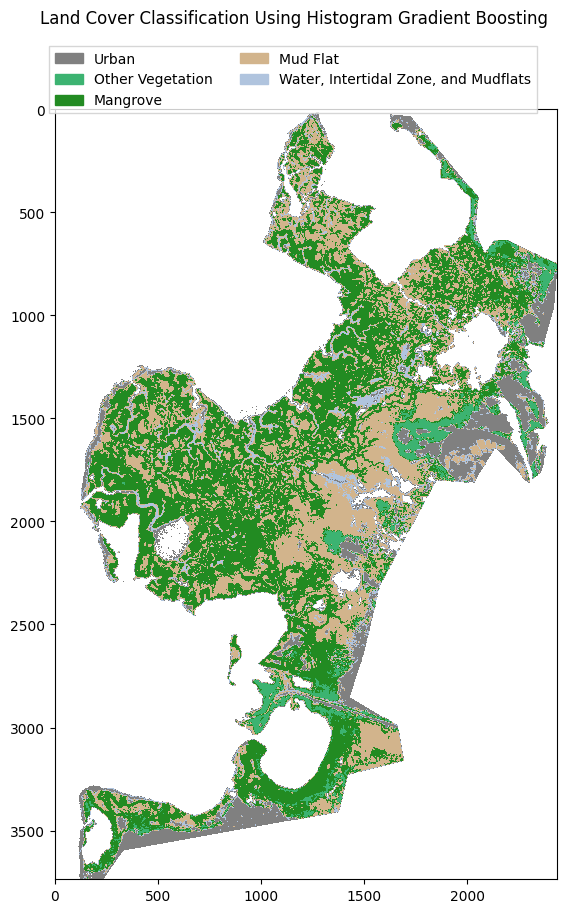

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(classified, cmap=custom_cmap)
fig.legend(handles=patches, fancybox=False, bbox_to_anchor=(0.75,0.95), ncol=2)
fig.suptitle('Land Cover Classification Using Histogram Gradient Boosting')
#fig.patch.set_facecolor('xkcd:white')
plt.show()

/global/home/users/alexandregeorges/.conda/envs/MangroveRS/lib/python3.11/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


<Axes: >

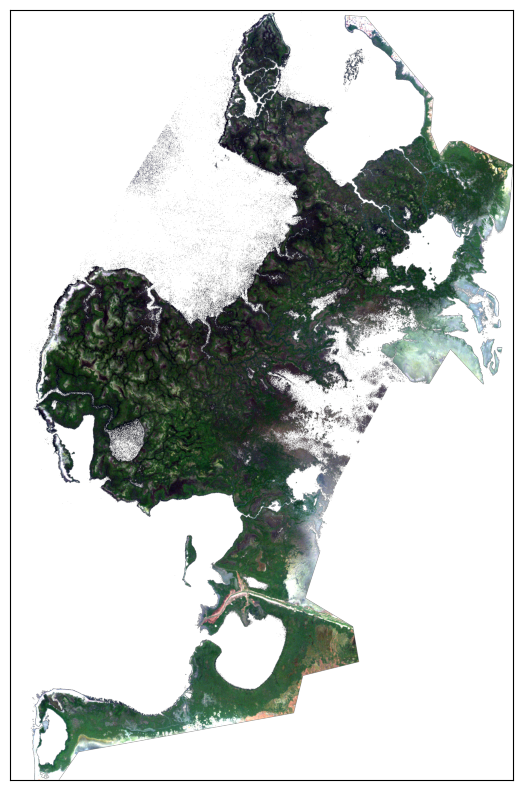

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ep.plot_rgb(sites[0][times[-2]], rgb=[2,1,0], stretch=True, ax=ax)

## Export

In [34]:
classified_ds.to_netcdf(CLASSIFIED_PREFIX+site_code+'_classified.nc')